# 데이터 불러오기 및 전처리

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, roc_auc_score, recall_score, classification_report, silhouette_score, precision_score, accuracy_score
from sklearn.cluster import DBSCAN, KMeans
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, train_test_split
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# import matplotlib
# from matplotlib import font_manager

# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv

# fontpaths = ["/usr/share/fonts/truetype/nanum/"]
# font_files = font_manager.findSystemFonts(fontpaths=fontpaths)

# for ff in font_files:
#     font_manager.fontManager.addfont(ff)

# matplotlib.rc('font', family="NanumGothic")
# matplotlib.rcParams['axes.unicode_minus'] = False

In [ ]:
DATA_PATH = "/content/drive/MyDrive/멋쟁이사자처럼/DataThon/dataset/Moulding/"
SEED = 42

In [ ]:
train = pd.read_csv(f"{DATA_PATH}train_cn7.csv")    # cn7 / rg3
test = pd.read_csv(f"{DATA_PATH}test_cn7.csv")  # cn7 / rg3
unlab = pd.read_csv(f"{DATA_PATH}unlab_cn7.csv")    # cn7 / rg3

unlab.drop(columns=["Unnamed: 0"], inplace=True)

train['PART_FACT_SERIAL'] = train['PART_FACT_SERIAL'].astype(object)
test['PART_FACT_SERIAL'] = test['PART_FACT_SERIAL'].astype(object)
unlab['PART_FACT_SERIAL'] = unlab['PART_FACT_SERIAL'].astype(object)

labeled = pd.concat([train, test], axis=0)
serial = labeled["PART_FACT_SERIAL"].unique().tolist()

unlab = unlab[unlab["EQUIP_NAME"] == "650톤-우진2호기"]
unlab = unlab[unlab["PART_FACT_SERIAL"].isin(serial)]
unlab = unlab[unlab["Switch_Over_Position"] == 0]

train_ft = train.copy()
test_ft = test.copy()
unlab_ft = unlab.copy()

train_ft = labeled[:train_ft.shape[0]].copy()
test_ft = labeled[train_ft.shape[0]:].copy()

label_drop_cols = ["_id", "TimeStamp", "PART_FACT_PLAN_DATE", "EQUIP_CD", "EQUIP_NAME", "PassOrFail", "Reason", 'Barrel_Temperature_7',
             'Mold_Temperature_1', 'Mold_Temperature_2', 'Mold_Temperature_5', 'Mold_Temperature_6', 'Mold_Temperature_7',
             'Mold_Temperature_8', 'Mold_Temperature_9', 'Mold_Temperature_10', 'Mold_Temperature_11', 'Mold_Temperature_12']
unlab_drop_cols = [col for col in unlab_ft.columns if col not in train_ft.columns] + [col for col in label_drop_cols if col in unlab_ft.columns]

train_ft = train_ft.drop(label_drop_cols, axis=1).copy()
test_ft = test_ft.drop(label_drop_cols, axis=1).copy()
unlab_ft = unlab_ft.drop(unlab_drop_cols, axis=1).copy()

# 학습용 정답데이터 => 제품마다 코드 수정 필요
y_train = (train['PassOrFail'] == 'N').astype(int)

# 테스트용 정답데이터 => 제품마다 코드 수정 필요
target = (test['PassOrFail'] == 'N').astype(int)

def preprocess(df, test=False, enc=None, scaler=None):
    obj_col = df.select_dtypes('object').columns

    if not(test):
        enc = OneHotEncoder(handle_unknown='ignore')
        enc.fit(df[obj_col])
    df[enc.get_feature_names_out()] = enc.transform(df[obj_col]).toarray()
    df.drop(obj_col, axis=1, inplace=True)

    if not(test):
        scaler = RobustScaler()
        scaler.fit(df)
    df = scaler.transform(df)

    return df, enc, scaler

train_ft, enc, scaler = preprocess(train_ft)
test_ft, _, _ = preprocess(test_ft, test=True, enc=enc, scaler=scaler)
unlab_ft, _, _ = preprocess(unlab_ft, test=True, enc=enc, scaler=scaler)

train_ft.shape, test_ft.shape, unlab_ft.shape, y_train.shape, target.shape

((2400, 35), (1574, 35), (10048, 35), (2400,), (1574,))

In [ ]:
valid_ft, test_ft, valid_target, target = train_test_split(test_ft, target, test_size=0.65, random_state=SEED, shuffle=True, stratify=target)
valid_ft.shape, test_ft.shape, valid_target.shape, target.shape

((550, 35), (1024, 35), (550,), (1024,))

In [ ]:
train_ft.shape, test_ft.shape, unlab_ft.shape

((2400, 35), (1024, 35), (10048, 35))

# Pseudo Labeling

In [ ]:
min_sample = 10
eps = 2.0
usage_size = 0.6

stop_point = unlab_ft.shape[0] * (1 - usage_size)
X_train = train_ft.copy()
not_labeled = unlab_ft.copy()
outliers_data = np.empty((0, unlab_ft.shape[1]))

# while not_labeled.shape[0] >= stop_point:
for _ in range(1):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    model.fit(X_train)
    clustered_labels = model.fit_predict(not_labeled)

    core_sample_idx = model.core_sample_indices_  # core sample index
    core_samples = model.components_  # core sample data
    core_distances = np.min(pairwise_distances(not_labeled, core_samples), axis=1)    # 각 데이터가 가장 가까운 코어 샘플과의 거리

    normal_idx = np.where(clustered_labels != -1)[0]    # 정상
    outliers_idx = np.where(clustered_labels == -1)[0]  # 이상치 (-1)

    normal_top_idx = []
    unique_clusters = np.unique(clustered_labels[normal_idx])
    for cluster_id in unique_clusters:
        cluster_points = np.where(clustered_labels == cluster_id)[0]
        n_normal_top = max(1, int(len(cluster_points) * 0.05))
        top_idx = cluster_points[np.argsort(core_distances[cluster_points])[:n_normal_top]]
        normal_top_idx.extend(top_idx)

    n_outliers_top = max(1, int(len(outliers_idx) * 1))
    outliers_top_idx = outliers_idx[np.argsort(core_distances[outliers_idx])[:n_outliers_top]]

    # 정상, 이상치 데이터 추출
    pseudo_labeled_normal = not_labeled[normal_top_idx, :]
    pseudo_labeled_outliers = not_labeled[outliers_top_idx, :]

    X_train = np.vstack([X_train, pseudo_labeled_normal])  # 학습 데이터에 pseudo-labeled 정상 데이터 추가
    not_labeled = np.delete(not_labeled, np.concatenate([normal_top_idx, outliers_top_idx]), axis=0)
    outliers_data = np.vstack([outliers_data, pseudo_labeled_outliers]) if outliers_data.size > 0 else pseudo_labeled_outliers

    # # 하이퍼파라미터 업데이트 - eps
    # neighbors = NearestNeighbors(n_neighbors=5)
    # neighbors_fit = neighbors.fit(X_train)
    # distances, indices = neighbors_fit.kneighbors(X_train)
    # distances = np.sort(distances[:, -1])
    # diff = np.diff(distances)
    # diff2 = np.diff(diff)
    # elbow_index = np.argmax(diff2) + 1
    # eps = distances[elbow_index]  # 새로운 최적 eps

concat_ft = np.concatenate([X_train, outliers_data], axis=0)
target_normal, target_outliers = np.zeros(X_train.shape[0]), np.ones(outliers_data.shape[0])
concat_target = np.concatenate([target_normal, target_outliers], axis=0)

print(f"concat_ft Shape: {concat_ft.shape}")
print(f"concat_target Shape: {concat_target.shape}")
print(f"Outliers Shape: {outliers_data.shape}")
print(f"Outiliers Ratio: {np.mean(concat_target == 1):.4f}")

concat_ft Shape: (7914, 35)
concat_target Shape: (7914,)
Outliers Shape: (5279, 35)
Outiliers Ratio: 0.6670


- 한번만 돌렸을 때
    - eps : 2.0, min_samples : 36
    - lr : 0.7826
    - 이상치 개수 / 비율 : 5279, 66.7%

    - eps : 3.0, min_samples : 36
    - rf : 0.6000
    - 이상치 개수 / 비율 : 444, 13.37%

    - eps : 5.58624, min_samples : 36
    - rf : 0.5455
    - 이상치 개수 / 비율 : 133, 4.4%

In [ ]:
superviesed_modeling(concat_ft, concat_target, test_ft, target)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 5279, number of negative: 2635
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2142
[LightGBM] [Info] Number of data points in the train set: 7914, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.667046 -> initscore=0.694854
[LightGBM] [Info] Start training from score 0.694854
--------------------------------------------------------------------------------
Logistic Regression
f1_score : 0.7826
roc_auc : 0.8214
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1546
           1       1.00      0.64      0.78        28

    accuracy                           0.99      1574
   macro avg       1.00      0.82      0.89      1574
weighted avg       0.99      0.99      

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr

## 1차 비지도 학습 및 pseudo labeling

In [ ]:
model = DBSCAN(eps=12.58119167847988,
               min_samples=26)

model.fit(train_ft)

DBSCAN(eps=12.58119167847988, min_samples=26)

In [ ]:
pred = model.fit_predict(test_ft)

normal = test_ft[pred != -1]
anomalies = test_ft[pred == -1]
ratio = len(anomalies) / len(test_ft)

print(f"정상 : {len(normal)}, 이상치 : {len(anomalies)}, 이상치 비율 : {ratio:.4f}")

정상 : 1541, 이상치 : 33, 이상치 비율 : 0.0210


In [ ]:
pred = np.where(pred == -1, 1, 0)
print(f"f1_score : {f1_score(target, pred):.4f}")
print(classification_report(target, pred))

f1_score : 0.8852
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1546
           1       0.82      0.96      0.89        28

    accuracy                           1.00      1574
   macro avg       0.91      0.98      0.94      1574
weighted avg       1.00      1.00      1.00      1574



----

In [ ]:
clustered_labels = model.fit_predict(unlab_ft)
np.unique(clustered_labels) # -1은 이상치로 분류된

array([-1,  0,  1,  2,  3,  4,  5])

In [ ]:
core_sample_idx = model.core_sample_indices_  # core sample index
core_samples = model.components_  # core sample data

# 각 데이터가 가장 가까운 코어 샘플과의 거리
core_distances = np.min(pairwise_distances(unlab_ft, core_samples), axis=1)

outliers_idx = np.where(clustered_labels == -1)[0]  # 이상치 (-1)
normal_idx = np.where(clustered_labels != -1)[0]    # 정상

# 이상치 군집에서의 상위 10%
n_outliers_top = max(1, int(len(outliers_idx) * 0.1))  # 상위 10%, 최소 1개
outliers_top_idx = outliers_idx[np.argsort(core_distances[outliers_idx])[:n_outliers_top]]

# 이상치를 제외한 군집에서의 상위 10% (정상으로 간주된)
normal_top_idx = []
unique_clusters = np.unique(clustered_labels[normal_idx])
for cluster_id in unique_clusters:
    cluster_points = np.where(clustered_labels == cluster_id)[0]  # 해당 군집의 인덱스
    n_normal_top = max(1, int(len(cluster_points) * 0.1))  # 상위 10%, 최소 1개
    top_idx = cluster_points[np.argsort(core_distances[cluster_points])[:n_normal_top]]
    normal_top_idx.extend(top_idx)

pseudo_labeled_outliers = unlab_ft[outliers_top_idx]  # 이상치 상위 10%
pseudo_labeled_normal = unlab_ft[normal_top_idx]  # 군집별 상위 10%

# 결과 출력
print("Pseudo-labeled Outliers Shape:", pseudo_labeled_outliers.shape)
print("Pseudo-labeled normal Shape:", pseudo_labeled_normal.shape)

Pseudo-labeled Outliers Shape: (6, 34)
Pseudo-labeled normal Shape: (996, 34)


In [ ]:
# 기존 학습 데이터에 상위 10% 정상 데이터 추가
added_ft = np.vstack([train_ft, pseudo_labeled_normal])  # 정상 데이터 추가

# 상위 10% 이상치 데이터를 따로 저장
outliers_data = pseudo_labeled_outliers  # 이상치 데이터 저장

# 예측된 레이블이 없는 데이터에서 상위 10% 정상 및 이상치 데이터를 제외
remained_unlab_ft = np.delete(unlab_ft, np.concatenate([outliers_top_idx, normal_top_idx]), axis=0)

# 결과 출력
print(f"Updated Normal Data Shape: {added_ft.shape}")
print(f"Outliers Data Shape: {outliers_data.shape}")
print(f"Remaining Unlabeled Data Shape: {remained_unlab_ft.shape}")

Updated Normal Data Shape: (3396, 34)
Outliers Data Shape: (6, 34)
Remaining Unlabeled Data Shape: (9046, 34)


----

## 1차 pseudo labeling 후 다시 학습 및 예측

In [ ]:
model = DBSCAN(
    eps=12.58119167847988,
    min_samples=26)

model.fit(added_ft)

DBSCAN(eps=12.58119167847988, min_samples=26)

In [ ]:
pred = model.fit_predict(test_ft)

normal = test_ft[pred != -1]
anomalies = test_ft[pred == -1]
ratio = len(anomalies) / len(test_ft)

print(f"정상 : {len(normal)}, 이상치 : {len(anomalies)}, 이상치 비율 : {ratio:.4f}")

정상 : 1541, 이상치 : 33, 이상치 비율 : 0.0210


In [ ]:
pred = np.where(pred == -1, 1, 0)
print(f"f1_score : {f1_score(target, pred):.4f}")
print(classification_report(target, pred))

f1_score : 0.8852
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1546
           1       0.82      0.96      0.89        28

    accuracy                           1.00      1574
   macro avg       0.91      0.98      0.94      1574
weighted avg       1.00      1.00      1.00      1574



----

In [ ]:
clustered_labels = model.fit_predict(remained_unlab_ft)
np.unique(clustered_labels) # -1은 이상치로 분류된

array([-1,  0,  1,  2,  3,  4,  5])

In [ ]:
core_sample_idx = model.core_sample_indices_  # core sample index
core_samples = model.components_  # core sample data

# 각 데이터가 가장 가까운 코어 샘플과의 거리
core_distances = np.min(pairwise_distances(unlab_ft, core_samples), axis=1)

outliers_idx = np.where(clustered_labels == -1)[0]  # 이상치 (-1)
normal_idx = np.where(clustered_labels != -1)[0]    # 정상

# 이상치 군집에서의 상위 10%
n_outliers_top = max(1, int(len(outliers_idx) * 0.1))  # 상위 10%, 최소 1개
outliers_top_idx = outliers_idx[np.argsort(core_distances[outliers_idx])[:n_outliers_top]]

# 이상치를 제외한 군집에서의 상위 10% (정상으로 간주된)
normal_top_idx = []
unique_clusters = np.unique(clustered_labels[normal_idx])
for cluster_id in unique_clusters:
    cluster_points = np.where(clustered_labels == cluster_id)[0]  # 해당 군집의 인덱스
    n_normal_top = max(1, int(len(cluster_points) * 0.1))  # 상위 10%, 최소 1개
    top_idx = cluster_points[np.argsort(core_distances[cluster_points])[:n_normal_top]]
    normal_top_idx.extend(top_idx)

pseudo_labeled_outliers = remained_unlab_ft[outliers_top_idx]  # 이상치 상위 10%
pseudo_labeled_normal = remained_unlab_ft[normal_top_idx]  # 군집별 상위 10%

# 결과 출력
print("Pseudo-labeled Outliers Shape:", pseudo_labeled_outliers.shape)
print("Pseudo-labeled normal Shape:", pseudo_labeled_normal.shape)

Pseudo-labeled Outliers Shape: (5, 34)
Pseudo-labeled normal Shape: (896, 34)


In [ ]:
# 기존 학습 데이터에 상위 10% 정상 데이터 추가
added_ft = np.vstack([added_ft, pseudo_labeled_normal])  # 정상 데이터 추가

# 상위 10% 이상치 데이터를 따로 저장
outliers_data = np.vstack([outliers_data, pseudo_labeled_outliers]) if len(outliers_data) > 0 else pseudo_labeled_outliers  # 이상치 데이터 추가

# 예측된 레이블이 없는 데이터에서 상위 10% 정상 및 이상치 데이터를 제외
remained_unlab_ft = np.delete(remained_unlab_ft, np.concatenate([outliers_top_idx, normal_top_idx]), axis=0)

# 결과 출력
print(f"Updated Normal Data Shape: {added_ft.shape}")
print(f"Outliers Data Shape: {outliers_data.shape}")
print(f"Remaining Unlabeled Data Shape: {remained_unlab_ft.shape}")

Updated Normal Data Shape: (4292, 34)
Outliers Data Shape: (11, 34)
Remaining Unlabeled Data Shape: (8145, 34)


----

## 2차 pseudo labeling 후 다시 학습 및 예측

In [ ]:
model = DBSCAN(
    eps=12.58119167847988,
    min_samples=26)

model.fit(added_ft)

DBSCAN(eps=12.58119167847988, min_samples=26)

In [ ]:
pred = model.fit_predict(test_ft)

normal = test_ft[pred != -1]
anomalies = test_ft[pred == -1]
ratio = len(anomalies) / len(test_ft)

print(f"정상 : {len(normal)}, 이상치 : {len(anomalies)}, 이상치 비율 : {ratio:.4f}")

정상 : 1541, 이상치 : 33, 이상치 비율 : 0.0210


In [ ]:
pred = np.where(pred == -1, 1, 0)
print(f"f1_score : {f1_score(target, pred):.4f}")
print(classification_report(target, pred))

f1_score : 0.8852
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1546
           1       0.82      0.96      0.89        28

    accuracy                           1.00      1574
   macro avg       0.91      0.98      0.94      1574
weighted avg       1.00      1.00      1.00      1574



----

In [ ]:
clustered_labels = model.fit_predict(remained_unlab_ft)
np.unique(clustered_labels) # -1은 이상치로 분류된

array([-1,  0,  1,  2,  3,  4,  5])

In [ ]:
core_sample_idx = model.core_sample_indices_  # core sample index
core_samples = model.components_  # core sample data

# 각 데이터가 가장 가까운 코어 샘플과의 거리
core_distances = np.min(pairwise_distances(unlab_ft, core_samples), axis=1)

outliers_idx = np.where(clustered_labels == -1)[0]  # 이상치 (-1)
normal_idx = np.where(clustered_labels != -1)[0]    # 정상

# 이상치 군집에서의 상위 10%
n_outliers_top = max(1, int(len(outliers_idx) * 0.1))  # 상위 10%, 최소 1개
outliers_top_idx = outliers_idx[np.argsort(core_distances[outliers_idx])[:n_outliers_top]]

# 이상치를 제외한 군집에서의 상위 10% (정상으로 간주된)
normal_top_idx = []
unique_clusters = np.unique(clustered_labels[normal_idx])
for cluster_id in unique_clusters:
    cluster_points = np.where(clustered_labels == cluster_id)[0]  # 해당 군집의 인덱스
    n_normal_top = max(1, int(len(cluster_points) * 0.1))  # 상위 10%, 최소 1개
    top_idx = cluster_points[np.argsort(core_distances[cluster_points])[:n_normal_top]]
    normal_top_idx.extend(top_idx)

pseudo_labeled_outliers = remained_unlab_ft[outliers_top_idx]  # 이상치 상위 10%
pseudo_labeled_normal = remained_unlab_ft[normal_top_idx]  # 군집별 상위 10%

# 결과 출력
print("Pseudo-labeled Outliers Shape:", pseudo_labeled_outliers.shape)
print("Pseudo-labeled normal Shape:", pseudo_labeled_normal.shape)

Pseudo-labeled Outliers Shape: (5, 34)
Pseudo-labeled normal Shape: (806, 34)


In [ ]:
# 기존 학습 데이터에 상위 10% 정상 데이터 추가
added_ft = np.vstack([added_ft, pseudo_labeled_normal])  # 정상 데이터 추가

# 상위 10% 이상치 데이터를 따로 저장
outliers_data = np.vstack([outliers_data, pseudo_labeled_outliers]) if len(outliers_data) > 0 else pseudo_labeled_outliers  # 이상치 데이터 추가

# 예측된 레이블이 없는 데이터에서 상위 10% 정상 및 이상치 데이터를 제외
remained_unlab_ft = np.delete(remained_unlab_ft, np.concatenate([outliers_top_idx, normal_top_idx]), axis=0)

# 결과 출력
print(f"Updated Normal Data Shape: {added_ft.shape}")
print(f"Outliers Data Shape: {outliers_data.shape}")
print(f"Remaining Unlabeled Data Shape: {remained_unlab_ft.shape}")

Updated Normal Data Shape: (5098, 34)
Outliers Data Shape: (16, 34)
Remaining Unlabeled Data Shape: (7334, 34)


# DBSCAN - Pseudo Labeling 자동화 (수정)

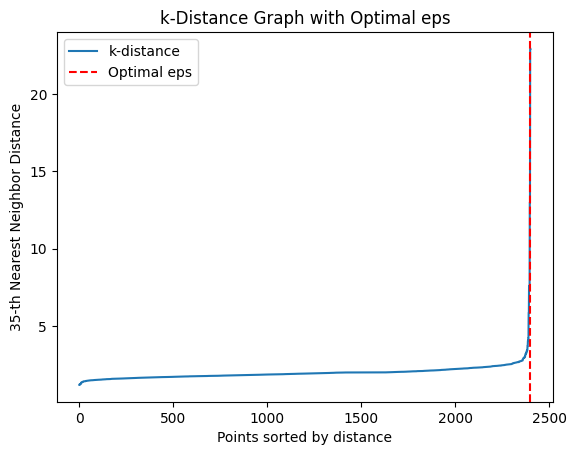

Optimal eps: 12.9912


In [ ]:
# k = min_samples - 1
min_samples = 36
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(train_ft)
distances, indices = neighbors_fit.kneighbors(train_ft)

# 거리 정렬
distances = np.sort(distances[:, -1])  # k번째 이웃 거리

# 1차 차분(기울기)
diff = np.diff(distances)

# 2차 차분(기울기 변화)
diff2 = np.diff(diff)

# 최대 기울기 변화 지점 찾기
elbow_index = np.argmax(diff2) + 1  # +1은 diff 차원 감소 보정

# 시각화
plt.plot(distances, label="k-distance")
plt.axvline(x=elbow_index, color="r", linestyle="--", label="Optimal eps")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{min_samples - 1}-th Nearest Neighbor Distance")
plt.legend()
plt.title("k-Distance Graph with Optimal eps")
plt.show()

print(f"Optimal eps: {distances[elbow_index]:.4f}")

```python
    "concat_size": 0.02, # 한번에 얼마나 레이블링 할지
    "abnormal_rate": 0.01, # 이상치를 얼마나 추출할지
    "usage_size":0.5, # unlab_ft에서 사용할 비율
```

## 원본 코드

In [ ]:
threshold = 0.1
remaining_ratio = 1.0

def pseudo_labeling(train_ft, unlab_ft, using_ratio, eps=12.991, min_samples=35, threshold=threshold, remaining_ratio=remaining_ratio):
    outliers_data = np.empty((0, unlab_ft.shape[1]))
    x = train_ft.copy()
    y = unlab_ft.copy()
    iter = 1
    while remaining_ratio > (1 - using_ratio):
        print("\n")
        print(f"--- {iter}차 Pseudo Labeling ---")

        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(x)

        clustered_labels = model.fit_predict(y)
        core_sample_idx = model.core_sample_indices_  # core sample index
        core_samples = model.components_  # core sample data

        # 각 데이터가 가장 가까운 코어 샘플과의 거리
        core_distances = np.min(pairwise_distances(y, core_samples), axis=1)

        outliers_idx = np.where(clustered_labels == -1)[0]  # 이상치 (-1)
        normal_idx = np.where(clustered_labels != -1)[0]    # 정상

        # 이상치 군집에서의 상위 10%
        n_outliers_top = max(1, int(len(outliers_idx) * 0.1))  # 상위 10%, 최소 1개
        outliers_top_idx = outliers_idx[np.argsort(core_distances[outliers_idx])[:n_outliers_top]]

        # 이상치를 제외한 군집에서의 상위 10% (정상으로 간주된)
        normal_top_idx = []
        unique_clusters = np.unique(clustered_labels[normal_idx])
        for cluster_id in unique_clusters:
            cluster_points = np.where(clustered_labels == cluster_id)[0]  # 정상 군집의 인덱스
            n_normal_top = max(1, int(len(cluster_points) * 0.1))  # 상위 10%, 최소 1개
            top_idx = cluster_points[np.argsort(core_distances[cluster_points])[:n_normal_top]]
            normal_top_idx.extend(top_idx)

        # 정상, 이상치 데이터 추출
        pseudo_labeled_outliers = y[outliers_top_idx]  # 이상치 군집 상위 10%
        pseudo_labeled_normal = y[normal_top_idx]  # 정상 군집별 상위 10%

        # 학습 데이터 및 이상치 데이터 업데이트
        x = np.vstack([x, pseudo_labeled_normal])  # 학습 데이터에 pseudo-labeled 정상 데이터 추가
        y = np.delete(y, np.concatenate([outliers_top_idx, normal_top_idx]), axis=0)  # pseudo-labeled 데이터 제거
        outliers_data = np.vstack([outliers_data, pseudo_labeled_outliers]) if outliers_data.size > 0 else pseudo_labeled_outliers

        # 하이퍼파라미터 업데이트 - eps
        neighbors = NearestNeighbors(n_neighbors=min_samples)
        neighbors_fit = neighbors.fit(x)
        distances, indices = neighbors_fit.kneighbors(x)
        distances = np.sort(distances[:, -1])
        diff = np.diff(distances)
        diff2 = np.diff(diff)
        elbow_index = np.argmax(diff2) + 1
        eps = distances[elbow_index]  # 새로운 최적 eps

        remaining_ratio = len(y) / len(unlab_ft)

        # 진행상황 출력
        print("Pseudo-labeled normal Shape:", pseudo_labeled_normal.shape)
        print("Pseudo-labeled Outliers Shape:", pseudo_labeled_outliers.shape)
        print(f"Updated train_ft Shape: {x.shape}")
        print(f"Updated unlab_ft Shape: {y.shape}")
        print(f"Updated Outliers Shape: {outliers_data.shape}")
        print(f"Updated EPS : {eps}")
        print(f"Remaining Ratio: {remaining_ratio:.3f}")

        iter += 1

        if remaining_ratio <= (1 - using_ratio):
            break

    print("\n")
    print(f"train_ft Shape: {x.shape}")
    print(f"unlab_ft Shape: {y.shape}")
    print(f"Outliers Shape: {outliers_data.shape}")

    return x, y, outliers_data

## 수정 코드

In [ ]:
def pseudo_labeling_dbscan(train_ft, unlab_ft, concat_size=0.05, abnormal_rate=0.2, usage_size=0.7, eps=12.9912, min_samples=36):
    stop_point = unlab_ft.shape[0] * (1 - usage_size)
    X_train = train_ft.copy()
    not_labeled = unlab_ft.copy()
    outliers_data = np.empty((0, unlab_ft.shape[1]))

    while not_labeled.shape[0] >= stop_point:
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X_train)
        clustered_labels = model.fit_predict(not_labeled)

        core_sample_idx = model.core_sample_indices_  # core sample index
        core_samples = model.components_  # core sample data
        core_distances = np.min(pairwise_distances(not_labeled, core_samples), axis=1)    # 각 데이터가 가장 가까운 코어 샘플과의 거리

        normal_idx = np.where(clustered_labels != -1)[0]    # 정상
        outliers_idx = np.where(clustered_labels == -1)[0]  # 이상치 (-1)

        normal_top_idx = []
        unique_clusters = np.unique(clustered_labels[normal_idx])
        for cluster_id in unique_clusters:
            cluster_points = np.where(clustered_labels == cluster_id)[0]
            n_normal_top = max(1, int(len(cluster_points) * concat_size))
            top_idx = cluster_points[np.argsort(core_distances[cluster_points])[:n_normal_top]]
            normal_top_idx.extend(top_idx)

        n_outliers_top = max(1, int(len(outliers_idx) * abnormal_rate))
        outliers_top_idx = outliers_idx[np.argsort(core_distances[outliers_idx])[:n_outliers_top]]

        # 정상, 이상치 데이터 추출
        pseudo_labeled_outliers = not_labeled[outliers_top_idx, :]
        pseudo_labeled_normal = not_labeled[normal_top_idx, :]

        X_train = np.vstack([X_train, pseudo_labeled_normal])  # 학습 데이터에 pseudo-labeled 정상 데이터 추가
        all_indices_to_remove = np.unique(np.concatenate([outliers_top_idx, normal_top_idx]))
        not_labeled = np.delete(not_labeled, all_indices_to_remove, axis=0)
        outliers_data = np.vstack([outliers_data, pseudo_labeled_outliers]) if outliers_data.size > 0 else pseudo_labeled_outliers

        # # 하이퍼파라미터 업데이트 - eps
        # neighbors = NearestNeighbors(n_neighbors=5)
        # neighbors_fit = neighbors.fit(X_train)
        # distances, indices = neighbors_fit.kneighbors(X_train)
        # distances = np.sort(distances[:, -1])
        # diff = np.diff(distances)
        # diff2 = np.diff(diff)
        # elbow_index = np.argmax(diff2) + 1
        # eps = distances[elbow_index]  # 새로운 최적 eps

    concat_ft = np.concatenate([X_train, outliers_data], axis=0)
    target_normal, target_outliers = np.zeros(X_train.shape[0]), np.ones(outliers_data.shape[0])
    concat_target = np.concatenate([target_normal, target_outliers], axis=0)

    print(f"concat_ft Shape: {concat_ft.shape}")
    print(f"concat_target Shape: {concat_target.shape}")
    print(f"Outliers Shape: {outliers_data.shape}")
    print(f"Outiliers Ratio: {np.mean(concat_target == 1):.4f}")

    return concat_ft, concat_target, not_labeled

## 수정 코드 2차

In [ ]:
def pseudo_labeling_dbscan(train_ft, unlab_ft, concat_size=0.05, abnormal_rate=0.2, usage_size=0.6, eps=12.9912, min_samples=36):
    stop_point = unlab_ft.shape[0] * (1 - usage_size)
    X_train = train_ft.copy()
    not_labeled = unlab_ft.copy()
    outliers_data = np.empty((0, unlab_ft.shape[1]))

    while not_labeled.shape[0] >= stop_point:
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X_train)
        clustered_labels = model.fit_predict(not_labeled)

        core_sample_idx = model.core_sample_indices_  # core sample index
        core_samples = model.components_  # core sample data
        core_distances = np.min(pairwise_distances(not_labeled, core_samples), axis=1)    # 각 데이터가 가장 가까운 코어 샘플과의 거리

        normal_idx = np.where(clustered_labels != -1)[0]    # 정상
        outliers_idx = np.where(clustered_labels == -1)[0]  # 이상치 (-1)

        normal_top_idx = []
        unique_clusters = np.unique(clustered_labels[normal_idx])
        for cluster_id in unique_clusters:
            cluster_points = np.where(clustered_labels == cluster_id)[0]
            n_normal_top = max(1, int(len(cluster_points) * concat_size))
            top_idx = cluster_points[np.argsort(core_distances[cluster_points])[:n_normal_top]]
            normal_top_idx.extend(top_idx)

        n_outliers_top = max(1, int(len(outliers_idx) * abnormal_rate))
        outliers_top_idx = outliers_idx[np.argsort(core_distances[outliers_idx])[:n_outliers_top]]

        # 정상, 이상치 데이터 추출
        pseudo_labeled_normal = not_labeled[normal_top_idx, :]
        pseudo_labeled_outliers = not_labeled[outliers_top_idx, :]

        X_train = np.vstack([X_train, pseudo_labeled_normal])  # 학습 데이터에 pseudo-labeled 정상 데이터 추가
        not_labeled = np.delete(not_labeled, np.concatenate([normal_top_idx, outliers_top_idx]), axis=0)
        outliers_data = np.vstack([outliers_data, pseudo_labeled_outliers]) if outliers_data.size > 0 else pseudo_labeled_outliers

        # # 하이퍼파라미터 업데이트 - eps
        # neighbors = NearestNeighbors(n_neighbors=5)
        # neighbors_fit = neighbors.fit(X_train)
        # distances, indices = neighbors_fit.kneighbors(X_train)
        # distances = np.sort(distances[:, -1])
        # diff = np.diff(distances)
        # diff2 = np.diff(diff)
        # elbow_index = np.argmax(diff2) + 1
        # eps = distances[elbow_index]  # 새로운 최적 eps

    concat_ft = np.concatenate([X_train, outliers_data], axis=0)
    target_normal, target_outliers = np.zeros(X_train.shape[0]), np.ones(outliers_data.shape[0])
    concat_target = np.concatenate([target_normal, target_outliers], axis=0)

    print(f"concat_ft Shape: {concat_ft.shape}")
    print(f"concat_target Shape: {concat_target.shape}")
    print(f"Outliers Shape: {outliers_data.shape}")
    print(f"Outiliers Ratio: {np.mean(concat_target == 1):.4f}")

    return concat_ft, concat_target, not_labeled

In [ ]:
concat_ft, concat_target, not_labeled = pseudo_labeling_dbscan(train_ft, unlab_ft)

concat_ft Shape: (8466, 35)
concat_target Shape: (8466,)
Outliers Shape: (86, 35)
Outiliers Ratio: 0.0102
add_ft Shape: (6066, 35)
add_target Shape: (6066,)


# 지도학습

In [ ]:
def superviesed_modeling(train_ft, y_train, test_ft, target, seed=SEED):
    lr = LogisticRegression(random_state=seed)
    lr.fit(train_ft, y_train)
    lr_pred = lr.predict(test_ft)

    xgb = XGBClassifier(random_state=seed)
    xgb.fit(train_ft, y_train)
    xgb_pred = xgb.predict(test_ft)

    rf = RandomForestClassifier(random_state=seed)
    rf.fit(train_ft, y_train)
    rf_pred = rf.predict(test_ft)

    lgbm = LGBMClassifier(random_state=seed)
    lgbm.fit(train_ft, y_train)
    lgbm_pred = lgbm.predict(test_ft)

    print("-"*80)
    print("Logistic Regression")
    print(f"f1_score : {f1_score(target, lr_pred):.4f}")
    print(f"roc_auc : {roc_auc_score(target, lr_pred):.4f}")
    print(classification_report(target, lr_pred))
    print("-"*80)

    print("XGBoost")
    print(f"f1_score : {f1_score(target, xgb_pred):.4f}")
    print(f"roc_auc : {roc_auc_score(target, xgb_pred):.4f}")
    print(classification_report(target, xgb_pred))
    print("-"*80)

    print("Random Forest")
    print(f"f1_score : {f1_score(target, rf_pred):.4f}")
    print(f"roc_auc : {roc_auc_score(target, rf_pred):.4f}")
    print(classification_report(target, rf_pred))
    print("-"*80)

    print("LightGBM")
    print(f"f1_score : {f1_score(target, lgbm_pred):.4f}")
    print(f"roc_auc : {roc_auc_score(target, lgbm_pred):.4f}")
    print(classification_report(target, lgbm_pred))

In [ ]:
superviesed_modeling(concat_ft, concat_target, test_ft, target)

## 0117 지도학습 점수 기록
- unlab_ft 90% 사용 + (concat_size=0.05, abnormal_rate=0.15) + 이상치 비율 1.21%
    - lr : 0.4444
    - xgboost : 0.2424
    - rf : 0.4211
    - lgbm : 0.4211

- unlab_ft 90% 사용 + (concat_size=0.05, abnormal_rate=0.1) + 이상치 비율 1.13%
    - lr : 0.4444
    - xgboost : 0.0000
    - rf : 0.4211
    - lgbm : 0.4211

- unlab_ft 50% 사용 + (concat_size=0.1, abnormal_rate=0.1) + 이상치 비율 0.94% + 불량품 37개
    - lr : 0.4444
    - xgboost : 0.0000
    - rf : 0.4211
    - lgbm : 0.4211

- unlab_ft 50% 사용 + (concat_size=0.05, abnormal_rate=0.2) + 이상치 비율 0.49% + 불량품 71개
    - lr : 0.4444
    - xgboost : 0.1333
    - rf : 0.4211
    - lgbm : 0.2353

- unlab_ft 60% 사용 + (concat_size=0.05, abnormal_rate=0.2) + 이상치 비율 1.02% + 불량품 86개
    - lr : 0.4444
    - xgboost : 0.3333
    - rf : 0.4211
    - lgbm : 0.4211

- unlab_ft 60% 사용 + train_ft 2400개 제외 + (concat_size=0.05, abnormal_rate=0.2) + 이상치 비율 1.02% + 불량품 86개
    - lr : 0.4444
    - xgboost : 0.3810
    - rf : 0.3810
    - lgbm : 0.3810
    - 결국 비율 차이라 상관이 없는 것 같다.

- unlab_ft 70% 사용 + (concat_size=0.05, abnormal_rate=0.2) + 이상치 비율 1.12% + 불량품 107개
    - lr : 0.3529
    - xgboost : 0.3333
    - rf : 0.4211
    - lgbm : 0.4211



----

## 0116 지도학습 점수 기록
- eps 지속적으로 업데이트
    - lr : 0.3030
    - xgboost : 0.2500
    - rf : 0.4211
    - lgbm : 0.4211

- unlab_ft 50% 사용 + eps 지속적으로 업데이트
    - lr : 0.4444
    - xgboost : 0.2353
    - rf : 0.4211
    - lgbm : 0.4211

- default 파라미터 수정 + unlab_ft 20% 사용 + eps 지속적으로 업데이트
    - lr : 0.4444
    - xgboost : 0.2353
    - rf : 0.4211
    - lgbm : 0.3529

- ***default 파라미터 수정 + unlab_ft 30% 사용 + eps 지속적으로 업데이트***
    - lr : 0.4444
    - xgboost : 0.4211
    - rf : 0.4211
    - lgbm : 0.4211

- default 파라미터 수정 + unlab_ft 40% 사용 + eps 지속적으로 업데이트
    - lr : 0.4444
    - xgboost : 0.1250
    - rf : 0.4211
    - lgbm : 0.4211

- default 파라미터 수정 + unlab_ft 50% 사용 + eps 지속적으로 업데이트
    - lr : 0.4444
    - xgboost : 0.2353
    - rf : 0.4211
    - lgbm : 0.4211

- default 파라미터 수정 + unlab_ft 60% 사용 + eps 지속적으로 업데이트
    - lr : 0.4444
    - xgboost : 0.2353
    - rf : 0.3784
    - lgbm : 0.0000

- default 파라미터 수정 + unlab_ft 70% 사용 + eps 지속적으로 업데이트
    - lr : 0.3529
    - xgboost : 0.0000
    - rf : 0.4211
    - lgbm : 0.4211

- default 파라미터 수정 + unlab_ft 80% 사용 + eps 지속적으로 업데이트
    - lr : 0.0000
    - xgboost : 0.2500
    - rf : 0.3333
    - lgbm : 0.4211

- default 파라미터 수정 + unlab_ft 90% 사용 + eps 지속적으로 업데이트
    - lr : 0.1333
    - xgboost : 0.1333
    - rf : 0.4211
    - lgbm : 0.4211


# 오버샘플링

## SMOTE

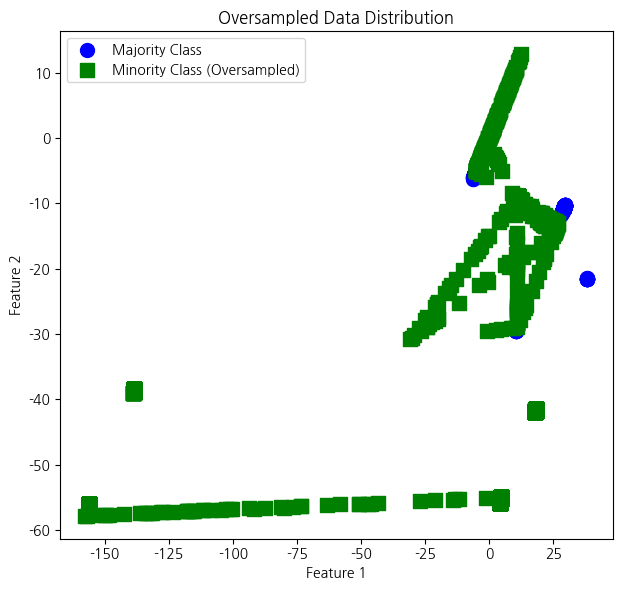

In [ ]:
from imblearn.over_sampling import SMOTE

# SMOTE를 사용하여 소수 클래스 오버샘플링
smote = SMOTE(sampling_strategy=0.5, random_state=SEED)
X_resampled, y_resampled = smote.fit_resample(concat_ft, concat_target)

# 오버샘플링 후 데이터 분포 시각화
plt.figure(figsize=(12, 6))

# 오버샘플링 후 플롯
plt.subplot(1, 2, 2)
plt.scatter(X_resampled[y_resampled == 0][:, 0], X_resampled[y_resampled == 0][:, 1], label="Majority Class", c='blue', marker='o', s=100)
plt.scatter(X_resampled[y_resampled == 1][:, 0], X_resampled[y_resampled == 1][:, 1], label="Minority Class (Oversampled)", c='green', marker='s', s=100)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Oversampled Data Distribution")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from collections import Counter
print("클래스 분포 (이전):", Counter(concat_target))
print("클래스 분포 (이후):", Counter(y_resampled))

클래스 분포 (이전): Counter({0.0: 8380, 1.0: 86})
클래스 분포 (이후): Counter({0.0: 8380, 1.0: 4190})


In [ ]:
superviesed_modeling(X_resampled, y_resampled, test_ft, target)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4190, number of negative: 8380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6827
[LightGBM] [Info] Number of data points in the train set: 12570, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
--------------------------------------------------------------------------------
Logistic Regression
f1_score : 0.4444
roc_auc : 0.6429
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1546
           1       1.00      0.29      0.44        28

    accuracy                           0.99      1574
   macro avg       0.99      0.64      0.72      1574
weighted avg       0.99      0.99   

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## ADASYN

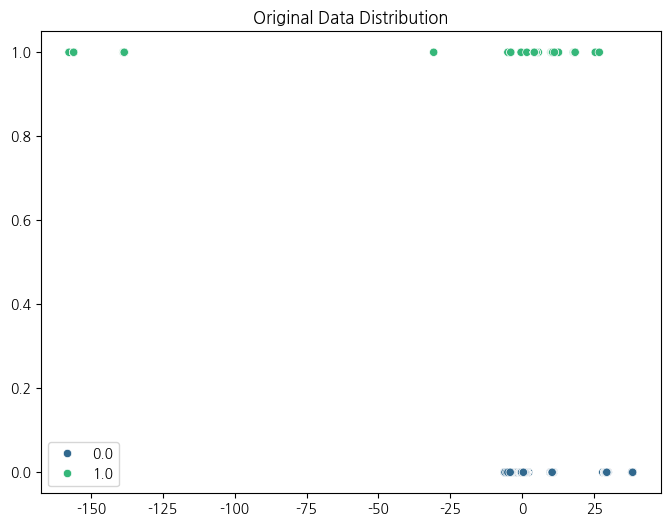

In [ ]:
# 데이터 시각화 (원본 데이터)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=concat_ft[:, 0], y=concat_target, hue=concat_target, palette='viridis') # Changed this line
plt.title("Original Data Distribution")
plt.show()

In [ ]:
from imblearn.over_sampling import ADASYN

# ADASYN 적용
adasyn = ADASYN(sampling_strategy=0.5, random_state=SEED)
X_resampled, y_resampled = adasyn.fit_resample(concat_ft, concat_target)

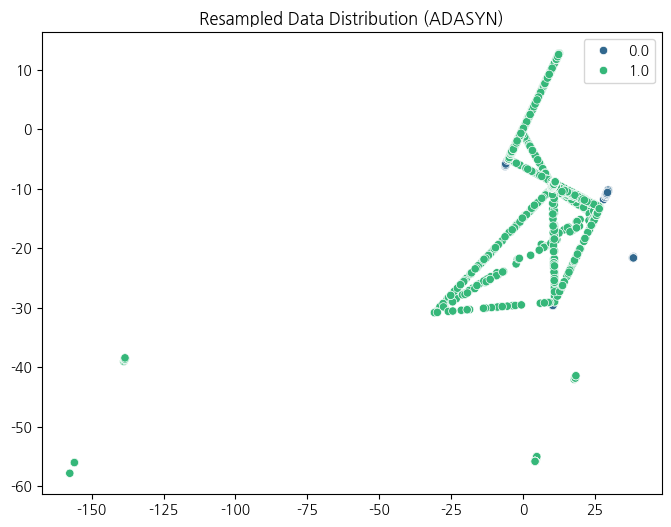

In [ ]:
# 데이터 시각화 (ADASYN 적용 후 데이터)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_resampled[:, 0], y=X_resampled[:, 1], hue=y_resampled, palette='viridis')
plt.title("Resampled Data Distribution (ADASYN)")
plt.show()

In [ ]:
# 3. 결과 확인
original_class_distribution = pd.Series(concat_target).value_counts()
resampled_class_distribution = pd.Series(y_resampled).value_counts()

print("Original Class Distribution:")
print(original_class_distribution)

print("\nResampled Class Distribution:")
print(resampled_class_distribution)

Original Class Distribution:
0.0    8380
1.0      86
Name: count, dtype: int64

Resampled Class Distribution:
0.0    8380
1.0    4187
Name: count, dtype: int64


In [ ]:
superviesed_modeling(X_resampled, y_resampled, test_ft, target)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4187, number of negative: 8380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7449
[LightGBM] [Info] Number of data points in the train set: 12567, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333174 -> initscore=-0.693863
[LightGBM] [Info] Start training from score -0.693863
--------------------------------------------------------------------------------
Logistic Regression
f1_score : 0.4444
roc_auc : 0.6429
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1546
           1       1.00      0.29      0.44        28

    accuracy                           0.99      1574
   macro avg       0.99      0.64      0.72      1574
weighted avg       0.99      0.99   

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
